### set `folder_name` and `day`

In [13]:
name = 'ANB1'
session = '20231030_d5'
num_trials = 183

### imports and plot settings:

In [14]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd
import scipy.signal as signal
import scipy.interpolate as interpolate
import pickle
import glob # find files in a directory
import re # regex for string parsing

from common.set_matplotlib_settings import set_matplotlib_settings
from common.select_trials import select_hit_trials
from common.load_tonedisc_matfile import load_tonedisc_matfile
from velocity.get_velocity_movingavgs import get_velocity_movingavgs
from common.extract_movement_intervals import extract_movement_intervals
from common.make_percent_scaled import make_percent_scaled

### Setup folders and matfiles

In [15]:
tone_discriminiation_matfile = '../Data_Copy/ToneDiscrimination/'+name+'/ToneDisc_'+name+'_'+session+'.mat'
params, response, respMTX, MTXTrialType = load_tonedisc_matfile(tone_discriminiation_matfile)

PreprocessLeverData_folder = "../Data_Copy/AnalysisData/"+name+"/PreprocessLeverData_"+name+"_"+session+"/"
HitMovements_folder = "../Data_Copy/AnalysisData/"+name+"/HitMovements_"+name+"_"+session+"/"
output_folder = "../Data_Copy/AnalysisData/"+name+"/Velocity_"+name+"_"+session+"/"

respMTX shape: (183, 7)
MTXTrialType shape: (1000, 5)
number of trials: 183


ValueError: too many values to unpack (expected 4)

for mac:

In [ ]:
!mkdir {output_folder}

mkdir: ../Data_Copy/AnalysisData/ANB1/Velocity_ANB1_20231030_d5/: File exists


for windows:

In [ ]:
!mkdir "{output_folder}"

mkdir: ../Data_Copy/AnalysisData/ANB1/Velocity_ANB1_20231030_d5/: File exists


### Get velocity moving averages from an ~5 ms window (about 29 samples)

for a moving average filter, $\frac{1}{N} | \frac{\sin(wN/2)}{\sin(w/2)} | =0.5= -3 \text{dB}$

where

$w = 2\pi \frac{f_\text{cutoff}}{f_\text{sample}}$

$N=$ num samples per window


In [ ]:
N = 29
w = 2 * np.pi * (122/5888)
dB = (1/N) * np.abs(np.sin(w*N/2)/np.sin(w/2))
print(dB)

0.5037091144465476


So a window of 29 (aiming for ~5 ms given around 5888 Hz sampling frequency) which approximately gives a cutoff frequency of about 122 Hz according to the above calculation.

In [ ]:
window_duration = 0.005
get_velocity_movingavgs(window_duration, PreprocessLeverData_folder, num_trials, output_folder)

calculated samples per window of size 0.005 s: 24
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29
calculated samples per window of size 0.005 s: 29


### Extract just the leverpress movement velocities

In [ ]:
hit_movement_informations = np.load(HitMovements_folder+"leverpress_informations.npy")
velocities = extract_movement_intervals(hit_movement_informations, 'velocity', output_folder, PreprocessLeverData_folder, output_folder)

plot the velocities for hit trials

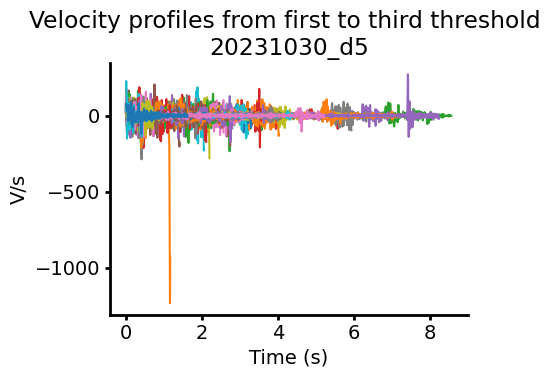

In [ ]:
set_matplotlib_settings()

for velocity in velocities:
    plt.plot(velocity[0,:],velocity[1,:])
plt.xlabel("Time (s)")
plt.ylabel("V/s")
plt.title("Velocity profiles from first to third threshold \n"+session)
plt.show()

### Make functions scaled from 0-100% of velocity path completion to analyze velocity path variability
These scaled 0-100% velocity path functions are made by linearly interpolating the original data at rates above sampling rate to make an approximate continuous function throughout the path. Right now, the `num_samples` = 10*10000 for a minimum sampling rate of 10kHz since __the velocities all take less than 10s__.

Save all of them together in `velocities_percent_scaled` and then into "velocities_percent_scaled.npy" file.

`velocities_percent_scaled`: rows are individual velocities, columns are samples (so left to right is going forward in time)

In [ ]:
hit_trials = select_hit_trials(respMTX, num_trials)
num_interpolation_samples = 10*10000
velocities_percent_scaled = make_percent_scaled(hit_trials, num_interpolation_samples, 'velocitymovement', output_folder, output_folder)

101  hit trials in this session.
percent scaled shape:  (101, 100000)


plot

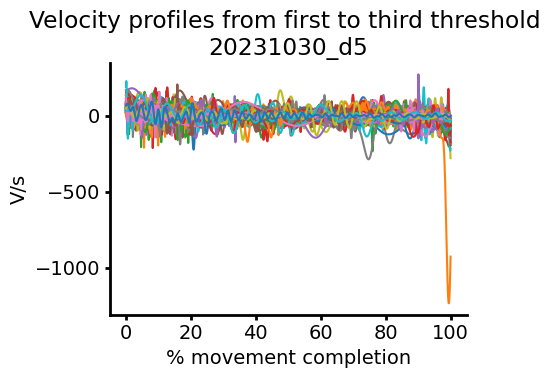

In [ ]:
x_range = np.array(range(0,num_interpolation_samples)) * 100 / num_interpolation_samples
for velocity_percent_scaled in velocities_percent_scaled:
    plt.plot(x_range, velocity_percent_scaled)
plt.xlabel("% movement completion")
plt.ylabel("V/s")
plt.title("Velocity profiles from first to third threshold \n"+session)
plt.show()

### plot the mean velocity, `mean_v`, across each movement in `velocities_percent_scaled` across % movement completed
axis=0 runs downwards across rows

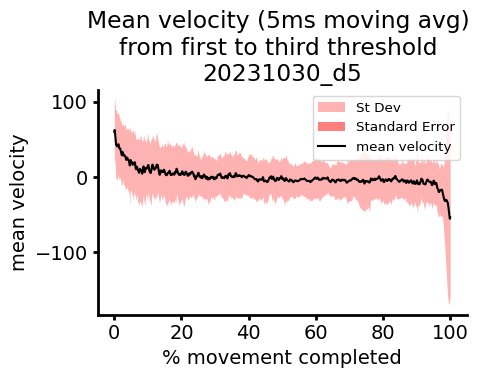

In [ ]:
mean_v=np.mean(velocities_percent_scaled, axis=0)
var_v=np.var(velocities_percent_scaled, axis=0)

num_velocity_trials = len(hit_trials)
std = np.sqrt(var_v)
standard_error = np.sqrt(var_v)/num_velocity_trials

plt.fill_between(x_range, mean_v+std, mean_v-std, color='red', alpha=0.3, label='St Dev', zorder=1, linewidth=0.0)
plt.fill_between(x_range, mean_v+standard_error, mean_v-standard_error, color='red', alpha=0.5, label='Standard Error', zorder=2, linewidth=0.0)
plt.plot(x_range, mean_v, label="mean velocity", zorder = 3, color='black')
plt.xlabel("% movement completed")
plt.ylabel("mean velocity")
plt.title("Mean velocity (5ms moving avg) \nfrom first to third threshold \n"+session)
plt.legend()
plt.show()